<a href="https://colab.research.google.com/github/GuptAmit725/DataScience_CaseStudies/blob/master/Amazon_food_reviews_KNN_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import nltk

In [ ]:
con = sqlite3.connect('/content/drive/My Drive/AAIC/18_2157_bundle_archive/database.sqlite')
data = pd.read_csv('/content/drive/My Drive/AAIC/18_2157_bundle_archive/Reviews.csv')
sql_data = pd.read_sql_query("""
SELECT * FROM Reviews
WHERE Score!=3
LIMIT 10000
""", con)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#Now we are replacing the 4,5,with positive and 1,2 as negative

def pos_neg(x):
  if x<3:
    return 'negative'
  return 'positive'

Actual_score = sql_data['Score']
updated_score = Actual_score.map(pos_neg)

sql_data['Score'] = updated_score


In [ ]:
sql_data['Score'].head()

0    positive
1    negative
2    positive
3    negative
4    positive
Name: Score, dtype: object

# ***2.Data Cleaning***

In [ ]:
# Checking for repeating user ID

(sql_data['UserId'].value_counts()>1).sum()

698

In [ ]:
s = pd.read_sql_query("""
SELECT * FROM Reviews
WHERE ProfileName= 'Geetha Krishnan'
""",con)

In [ ]:
sorted_data = sql_data.sort_values('ProductId', axis=0,inplace=False,kind='quicksort',na_position='last')
#De-duplication
deduplicated_data = sorted_data.drop_duplicates(subset = ['UserId','ProfileName','Score','Time','Summary','Text'],keep= 'first',inplace=False)

In [ ]:
deduplicated_data.shape

(9570, 10)

**HelpfulnessDenominator= yes+no
and HelpfulnessNumerator= yes

so HelpfulnessDenominator should always be greater than HelpfulnessNumerator**

In [ ]:
etc = pd.read_sql_query("""
SELECT * FROM Reviews
WHERE HelpfulnessNumerator > HelpfulnessDenominator
 """,con)

In [ ]:
final_data = deduplicated_data[deduplicated_data.HelpfulnessDenominator>=deduplicated_data.HelpfulnessNumerator]

In [ ]:
final_data.shape

(9570, 10)

In [ ]:
final_data['Score'].value_counts()

positive    7981
negative    1589
Name: Score, dtype: int64

In [ ]:
final_data.isna().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

# ***3.Text Preprocessing***

1. <html color='red'>Stop Words removal:</html color= 'red'> the, very, Not, is etc are non relevant words which do not add any meaning to the sentence except Not. So removing them makes my vectors error free. Although 'These' and 'The' do not add any meaning but if they are not removed then they will increase the distance between the vectors.

2. Stemming: Tasty, tastefull, tastes are similar meaining words. So if they are treated separately then the distance between the vectors will increase insipte of having similar meaning. So to avoid this problem we have Stemming. Which takes the base word 'taste' for all three meentioned words above.

3. Lemmatization: 'Delicious' and 'Tasty' are two complete different words with different base words but they are similar in meaning. If not treated properly they will increase the distance between two vectors drastically. So to solve this problem we have anothe algorithms known as 'Lemmatization'. Here it takes the content based meaning of the words.

4. W2V: By using Word2Vec we can get the semantics meanings of the words. 

Q. What we do in text preprocessing?<br>
Ans: 
1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)


In [ ]:
#Removing html tags
def htmltags(sentence):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', sentence)
  return cleantext

#Expanding shortcut words
def wordexpand(phrase):
    phrase = re.sub(r"won't","will not",phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase  

In [ ]:
import nltk
sw = nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from nltk.corpus import stopwords
sw_eng = stopwords.words("english")

In [ ]:
w = ['no','nor','not']
for i in w:
  if i in sw_eng:
    sw_eng.remove(i)

In [ ]:
from tqdm import tqdm
import re
from bs4 import BeautifulSoup
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentence in tqdm(final_data['Text'].values):
    sentence = sentence.lower()
    sentence = htmltags(sentence)
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = wordexpand(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentence.split() if e.lower() not in sw_eng)
    preprocessed_reviews.append(sentence.strip())

100%|██████████| 9570/9570 [00:03<00:00, 2403.88it/s]


In [ ]:
# Now we have processed review texts, now we will replace the text with processed texts
preprocessed_reviews[1500]

'i did not like these potatoe chips it is hot and sweet with an overwhelming taste of garlic it is also a bit salty'

In [ ]:
'''
from gensim.models import Word2Vec
list_of_sentences=[]
for sent in preprocessed_reviews:
  list_of_sentences.append(sent.split())
W2V_model = Word2Vec(list_of_sentences,min_count=1,size=50,workers=5)
print(W2V_model.wv.most_similar('joy'))
'''

[('knife', 0.9656607508659363), ('record', 0.9650447368621826), ('hair', 0.9649034738540649), ('shure', 0.9630676507949829), ('spray', 0.9610339999198914), ('pair', 0.959087610244751), ('rectum', 0.9581406712532043), ('edge', 0.9579895734786987), ('ab', 0.9565094709396362), ('gently', 0.9564011096954346)]


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
## Getting all the words in Word2Vec vocabulary

total_words = list(W2V_model.wv.vocab)
len(total_words)


18592

# *Avg Word2Vec*

In [ ]:
'''
avg_w2v_vec =[]

for sent in tqdm(list_of_sentences):
  sent_vec = np.zeros(50)
  c=0
  for words in sent:
    if words in total_words:
      vec=W2V_model.wv[words]
      sent_vec=sent_vec+vec
      c=c+1
    if c!=0:
      sent_vec = sent_vec/c  
  avg_w2v_vec.append(W2V_model.wv[words])
'''  


100%|██████████| 9570/9570 [00:19<00:00, 498.66it/s]


# TFIDF

In [ ]:
'''
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df = 10,max_features=5000)
tfidf.fit(preprocessed_reviews)
print('first 10 features:',tfidf.get_feature_names()[0:10])
tfidf_vec = tfidf.transform(preprocessed_reviews).toarray()
print(type(tfidf_vec))
'''


first 10 features: ['able', 'able to', 'about', 'about how', 'about it', 'about months', 'about the', 'about them', 'about these', 'about this']
<class 'numpy.ndarray'>


# *BOW*

In [ ]:
'''
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(ngram_range=(1,2), min_df = 10, max_features=5000)
bow.fit(preprocessed_reviews)

bow_vec = bow.transform(preprocessed_reviews).toarray()
'''


# *TFIDF-W2V*

In [ ]:
'''
dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_words = tfidf.get_feature_names()
W2V_words = W2V_model.wv.vocab
sentence_vec = np.zeros(50)
tfidf_w2v_vec=[]
for sent in list_of_sentences:
  sentence_vec = np.zeros(50)
  for word in sent:
    if word in W2V_words and word in tfidf_words:
      vec = W2V_model.wv[word]
      tfidf_val = dictionary[word]*(sent.count(word)/len(sent))
      sentence_vec+=vec*tfidf_val
  tfidf_w2v_vec.append(sentence_vec)
  '''

In [ ]:
'''
X_data = final_data.drop(['Id', 'ProductId', 'UserId', 'ProfileName','Score','Time','Summary','Text'],axis=1)
X_data_tfidf=X_data

data_tfidf=np.hstack((X_data_tfidf,tfidf_vec))
data_w2v=np.hstack((X_data_tfidf,avg_w2v_vec))
data_bow=np.hstack((X_data_tfidf,bow_vec))
data_tfidf_w2v=np.hstack((X_data_tfidf,tfidf_w2v_vec))


y=[1 if i=='positive' else 0 for i in final_data['Score'].values]
'''

# *Train Test Split*

In [ ]:
'''
from sklearn.model_selection import train_test_split
def data_split(X_data,y):
  X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.25, random_state=42)
  X_tr, X_cv, y_tr, y_cv = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
  return X_tr, y_tr, X_test, y_test, X_cv, y_cv

X_tr_bow, y_tr_bow, X_test_bow, y_test_bow, X_cv_bow, y_cv_bow = data_split(data_bow,y)   
X_tr_tfidf, y_tr_tfidf, X_test_tfidf, y_test_tfidf, X_cv_tfidf, y_cv_tfidf = data_split(data_tfidf,y)
X_tr_avgw2v, y_tr_avgw2v, X_test_avgw2v, y_test_avgw2v, X_cv_avgw2v, y_cv_avgw2v = data_split(data_w2v,y)   
X_tr_tfidf_w2v, y_tr_tfidf_w2v, X_test_tfidf_w2v, y_test_tfidf_w2v, X_cv_tfidf_w2v, y_cv_tfidf_w2v = data_split(data_tfidf_w2v,y)   
'''


In [ ]:
'''
#np.save('/content/drive/My Drive/AAIC/18_2157_bundle_archive/tr_data_bow',X_tr_bow)
np.save('/content/drive/My Drive/AAIC/18_2157_bundle_archive/tr_data_tfidf',X_tr_tfidf)
np.save('/content/drive/My Drive/AAIC/18_2157_bundle_archive/tr_data_tfidf_w2v',X_tr_tfidf_w2v)
np.save('/content/drive/My Drive/AAIC/18_2157_bundle_archive/tr_data_avgw2v',X_tr_avgw2v)


np.save('/content/drive/My Drive/AAIC/18_2157_bundle_archive/test_data_bow',X_test_bow)
np.save('/content/drive/My Drive/AAIC/18_2157_bundle_archive/test_data_tfidf',X_test_tfidf)
np.save('/content/drive/My Drive/AAIC/18_2157_bundle_archive/test_data_tfidf_w2v',X_test_tfidf_w2v)
np.save('/content/drive/My Drive/AAIC/18_2157_bundle_archive/test_data_avgw2v',X_test_avgw2v)

np.save('/content/drive/My Drive/AAIC/18_2157_bundle_archive/cv_data_bow',X_cv_bow)
np.save('/content/drive/My Drive/AAIC/18_2157_bundle_archive/cv_data_tfidf',X_cv_tfidf)
np.save('/content/drive/My Drive/AAIC/18_2157_bundle_archive/cv_data_tfidf_w2v',X_cv_tfidf_w2v)
np.save('/content/drive/My Drive/AAIC/18_2157_bundle_archive/cv_data_avgw2v',X_cv_avgw2v)

np.save('/content/drive/My Drive/AAIC/18_2157_bundle_archive/y_tr_data',y_tr_avgw2v)
np.save('/content/drive/My Drive/AAIC/18_2157_bundle_archive/y_test_data',y_test_avgw2v)
np.save('/content/drive/My Drive/AAIC/18_2157_bundle_archive/y_cv_data',y_cv_avgw2v)
'''

In [8]:
X_tr_bow = np.load('/content/drive/My Drive/AAIC/18_2157_bundle_archive/tr_data_bow.npy')
X_tr_tfidf = np.load('/content/drive/My Drive/AAIC/18_2157_bundle_archive/tr_data_tfidf.npy')
X_tr_tfidf_w2v = np.load('/content/drive/My Drive/AAIC/18_2157_bundle_archive/tr_data_tfidf_w2v.npy')
X_tr_avgw2v = np.load('/content/drive/My Drive/AAIC/18_2157_bundle_archive/tr_data_avgw2v.npy')

X_test_bow = np.load('/content/drive/My Drive/AAIC/18_2157_bundle_archive/test_data_bow.npy')
X_test_tfidf = np.load('/content/drive/My Drive/AAIC/18_2157_bundle_archive/test_data_tfidf.npy')
X_test_tfidf_w2v = np.load('/content/drive/My Drive/AAIC/18_2157_bundle_archive/test_data_tfidf_w2v.npy')
X_test_avgw2v = np.load('/content/drive/My Drive/AAIC/18_2157_bundle_archive/test_data_avgw2v.npy')

X_cv_bow = np.load('/content/drive/My Drive/AAIC/18_2157_bundle_archive/cv_data_bow.npy')
X_cv_tfidf = np.load('/content/drive/My Drive/AAIC/18_2157_bundle_archive/cv_data_tfidf.npy')
X_cv_tfidf_w2v = np.load('/content/drive/My Drive/AAIC/18_2157_bundle_archive/cv_data_tfidf_w2v.npy')
X_cv_avgw2v = np.load('/content/drive/My Drive/AAIC/18_2157_bundle_archive/cv_data_avgw2v.npy')


In [9]:
y_tr_bow = np.load('/content/drive/My Drive/AAIC/18_2157_bundle_archive/y_tr_data.npy')
y_tr_tfidf = np.load('/content/drive/My Drive/AAIC/18_2157_bundle_archive/y_tr_data.npy')
y_tr_tfidf_w2v = np.load('/content/drive/My Drive/AAIC/18_2157_bundle_archive/y_tr_data.npy')
y_tr_avgw2v = np.load('/content/drive/My Drive/AAIC/18_2157_bundle_archive/y_tr_data.npy')

y_test_bow = np.load('/content/drive/My Drive/AAIC/18_2157_bundle_archive/y_test_data.npy')
y_test_tfidf = np.load('/content/drive/My Drive/AAIC/18_2157_bundle_archive/y_test_data.npy')
y_test_tfidf_w2v = np.load('/content/drive/My Drive/AAIC/18_2157_bundle_archive/y_test_data.npy')
y_test_avgw2v = np.load('/content/drive/My Drive/AAIC/18_2157_bundle_archive/y_test_data.npy')

y_cv_bow = np.load('/content/drive/My Drive/AAIC/18_2157_bundle_archive/y_cv_data.npy')
y_cv_tfidf = np.load('/content/drive/My Drive/AAIC/18_2157_bundle_archive/y_cv_data.npy')
y_cv_tfidf_w2v = np.load('/content/drive/My Drive/AAIC/18_2157_bundle_archive/y_cv_data.npy')
y_cv_avgw2v = np.load('/content/drive/My Drive/AAIC/18_2157_bundle_archive/y_cv_data.npy')

In [10]:
print(X_tr_bow.shape, np.array(y_tr_bow).shape, X_test_bow.shape, np.array(y_test_bow).shape, X_cv_bow.shape, np.array(y_cv_bow).shape, sep = '\n')

(4808, 5002)
(4808,)
(2393, 5002)
(2393,)
(2369, 5002)
(2369,)



# ***1. KNN***


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def cross_validation(X_tr,X_cv,y_tr,y_cv):
  k = [1,3,5,7,9,11]
  accuracy_cv = []
  accuracy_tr = []
  for i in k:

    KNN = KNeighborsClassifier(i)
    KNN.fit(X_tr,y_tr)
    pred = KNN.predict(X_cv)
    pred_tr = KNN.predict(X_tr)
    acc_tr = accuracy_score(y_tr,pred_tr)
    acc = accuracy_score(y_cv,pred)
    accuracy_cv.append(acc)
    accuracy_tr.append(acc_tr)
    print('Accuracy for KNN with k={0} is {1}'.format(i,acc))

  return accuracy_cv, accuracy_tr


# *KNN with BOW*

In [ ]:
accuracy_cv,accuracy_tr = cross_validation(X_tr_bow,X_cv_bow,y_tr_bow,y_cv_bow)

Accuracy for KNN with k=1 is 0.8020261713803293
Accuracy for KNN with k=3 is 0.8290417897847193
Accuracy for KNN with k=5 is 0.8438159560996201
Accuracy for KNN with k=7 is 0.8459265512874631
Accuracy for KNN with k=9 is 0.8471929084001688
Accuracy for KNN with k=11 is 0.8463486703250317


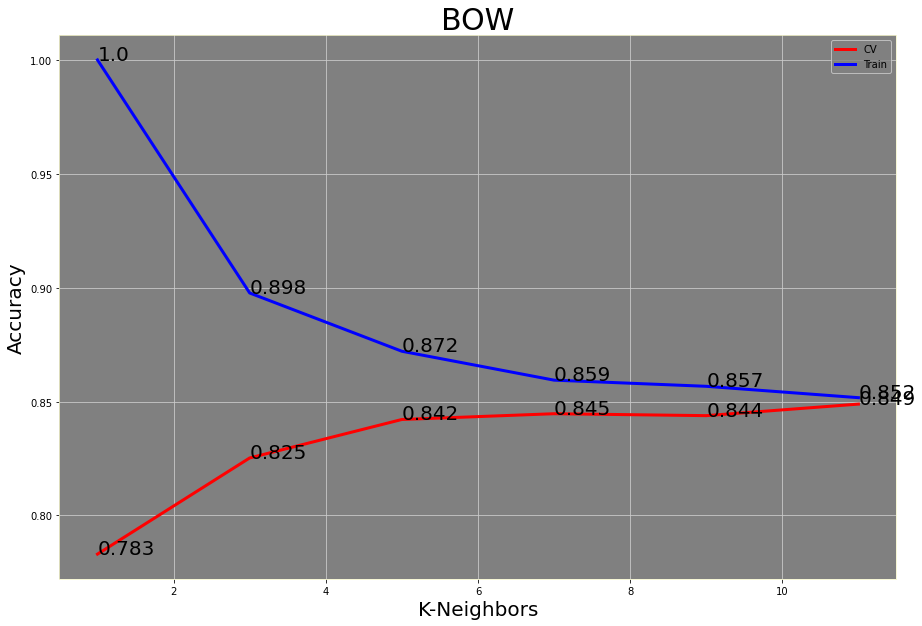

In [ ]:
plt.figure(figsize=(15,10))
plt.plot([1,3,5,7,9,11],accuracy_cv,color='red',linewidth=3)
plt.plot([1,3,5,7,9,11],accuracy_tr,color='blue',linewidth=3)
plt.xlabel('K-Neighbors',size=20)
plt.ylabel('Accuracy',size=20)
plt.title('BOW',size=30)
plt.rcParams['axes.facecolor'] = 'grey'
plt.rcParams['axes.edgecolor'] = '#F4F4CB'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
for i,j in zip([1,3,5,7,9,11],accuracy_cv):
 plt.annotate(round(j,3),xy=(i,j), size=20)
for i,j in zip([1,3,5,7,9,11],accuracy_tr):
 plt.annotate(round(j,3),xy=(i,j), size=20) 
plt.legend(['CV','Train'])  
plt.show() 

# *2. KNN with tf-idf*

Accuracy for KNN with k=1 is 0.8146897425073871
Accuracy for KNN with k=3 is 0.8526804558885606
Accuracy for KNN with k=5 is 0.8619670747150696
Accuracy for KNN with k=7 is 0.8649219079780498
Accuracy for KNN with k=9 is 0.865766146053187
Accuracy for KNN with k=11 is 0.8682988602785986


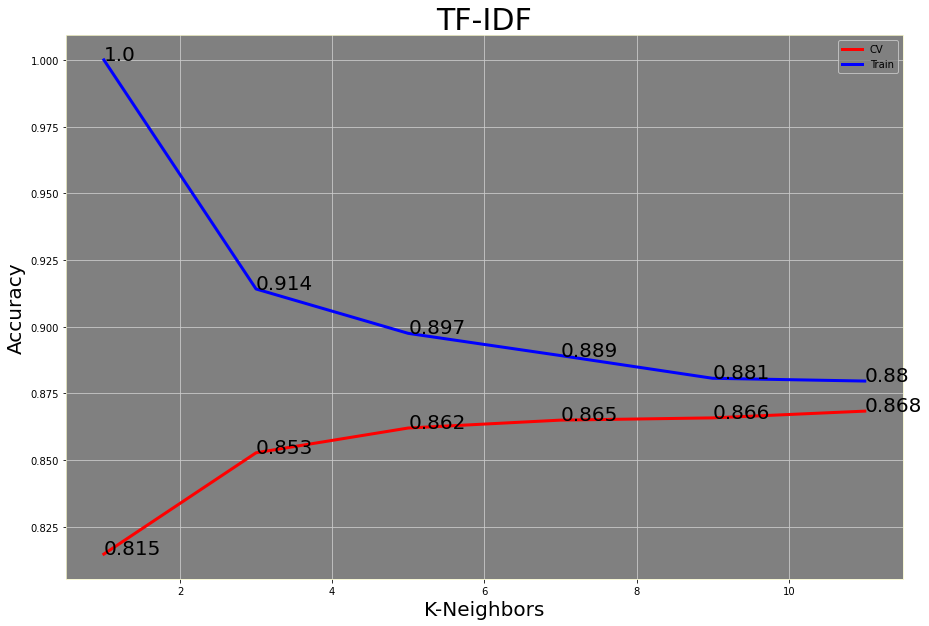

In [ ]:
accuracy_cv,accuracy_tr = cross_validation(X_tr_tfidf,X_cv_tfidf,y_tr_tfidf,y_cv_tfidf)

plt.figure(figsize=(15,10))
plt.plot([1,3,5,7,9,11],accuracy_cv,color='red',linewidth=3)
plt.plot([1,3,5,7,9,11],accuracy_tr,color='blue',linewidth=3)
plt.xlabel('K-Neighbors',size=20)
plt.ylabel('Accuracy',size=20)
plt.title('TF-IDF',size=30)
plt.rcParams['axes.facecolor'] = 'grey'
plt.rcParams['axes.edgecolor'] = '#F4F4CB'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
for i,j in zip([1,3,5,7,9,11],accuracy_cv):
 plt.annotate(round(j,3),xy=(i,j), size=20)
for i,j in zip([1,3,5,7,9,11],accuracy_tr):
 plt.annotate(round(j,3),xy=(i,j), size=20) 
plt.legend(['CV','Train'])  
plt.show() 

# *3. KNN wth Avg-W2V*

Accuracy for KNN with k=1 is 0.7631912199240186
Accuracy for KNN with k=3 is 0.8176445757703672
Accuracy for KNN with k=5 is 0.8395947657239341
Accuracy for KNN with k=7 is 0.8471929084001688
Accuracy for KNN with k=9 is 0.8455044322498945
Accuracy for KNN with k=11 is 0.8467707893626003


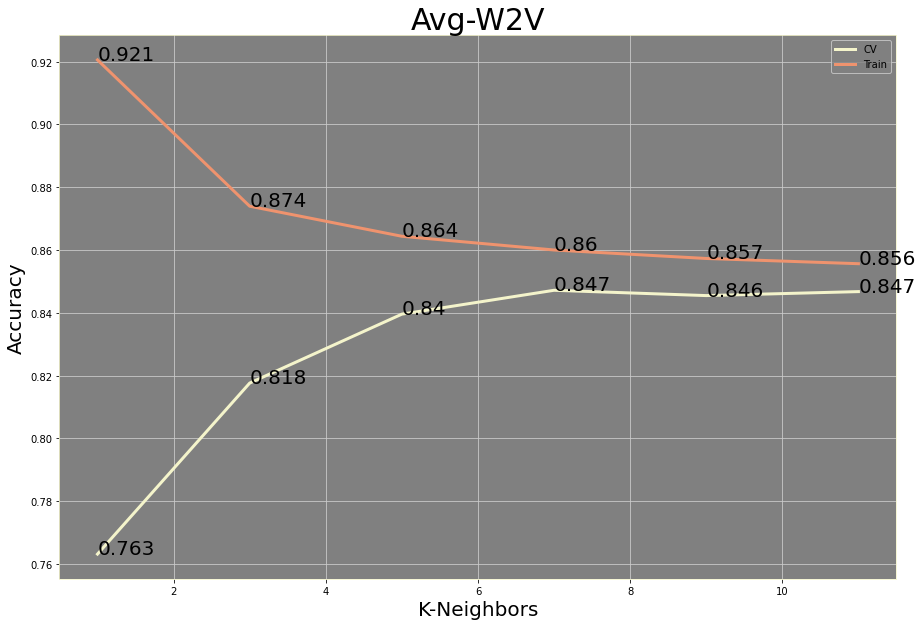

In [ ]:
accuracy_cv,accuracy_tr = cross_validation(X_tr_avgw2v,X_cv_avgw2v,y_tr_avgw2v,y_cv_avgw2v)

plt.figure(figsize=(15,10))
plt.plot([1,3,5,7,9,11],accuracy_cv,color='#F4F4CB',linewidth=3)
plt.plot([1,3,5,7,9,11],accuracy_tr,color='#EF936E',linewidth=3)
plt.xlabel('K-Neighbors',size=20)
plt.ylabel('Accuracy',size=20)
plt.title('Avg-W2V',size=30)
plt.rcParams['axes.facecolor'] = 'grey'
plt.rcParams['axes.edgecolor'] = '#F4F4CB'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
for i,j in zip([1,3,5,7,9,11],accuracy_cv):
 plt.annotate(round(j,3),xy=(i,j), size=20)
for i,j in zip([1,3,5,7,9,11],accuracy_tr):
 plt.annotate(round(j,3),xy=(i,j), size=20) 
plt.legend(['CV','Train']) 
plt.show() 

# *4. KNN with Tfidf-w2v*

Accuracy for KNN with k=1 is 0.7830308146897426
Accuracy for KNN with k=3 is 0.8252427184466019
Accuracy for KNN with k=5 is 0.8421274799493457
Accuracy for KNN with k=7 is 0.8446601941747572
Accuracy for KNN with k=9 is 0.8438159560996201
Accuracy for KNN with k=11 is 0.8488813845504433


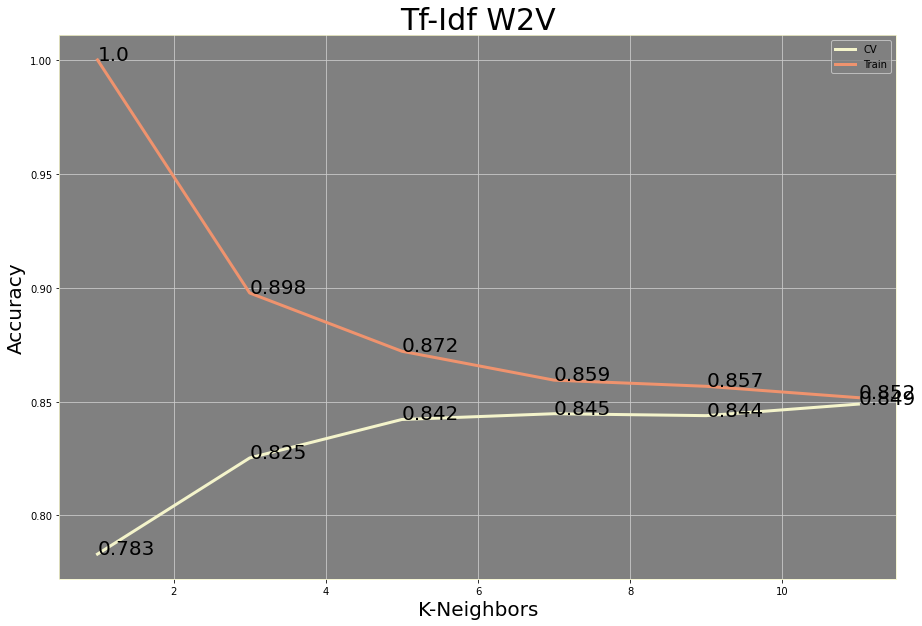

In [ ]:
accuracy_cv,accuracy_tr = cross_validation(X_tr_tfidf_w2v,X_cv_tfidf_w2v,y_tr_tfidf_w2v,y_cv_tfidf_w2v)

plt.figure(figsize=(15,10))
plt.plot([1,3,5,7,9,11],accuracy_cv,color='#F4F4CB',linewidth=3)
plt.plot([1,3,5,7,9,11],accuracy_tr,color='#EF936E',linewidth=3)
plt.xlabel('K-Neighbors',size=20)
plt.ylabel('Accuracy',size=20)
plt.title('Tf-Idf W2V',size=30)
plt.rcParams['axes.facecolor'] = 'grey'
plt.rcParams['axes.edgecolor'] = '#F4F4CB'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
for i,j in zip([1,3,5,7,9,11],accuracy_cv):
 plt.annotate(round(j,3),xy=(i,j), size=20)
for i,j in zip([1,3,5,7,9,11],accuracy_tr):
 plt.annotate(round(j,3),xy=(i,j), size=20) 
plt.legend(['CV','Train'])  
plt.show() 

In [ ]:
def test_performance(X_tr,X_test,y_tr,y_test):  
  from sklearn.neighbors import KNeighborsClassifier
  from sklearn.metrics import accuracy_score
  KNN = KNeighborsClassifier(n_neighbors=11)
  KNN.fit(X_tr,y_tr)
  test_acc = accuracy_score(y_test_bow,KNN.predict(X_test))
  return test_acc

In [ ]:
test_acc_bow = test_performance(X_tr_bow,X_test_bow,y_tr_bow,y_test_bow)
test_acc_tfidf = test_performance(X_tr_tfidf,X_test_tfidf,y_tr_tfidf,y_test_tfidf)
test_acc_tfidf_w2v = test_performance(X_tr_tfidf_w2v,X_test_tfidf_w2v,y_tr_tfidf_w2v,y_test_tfidf_w2v)
test_acc_w2v = test_performance(X_tr_avgw2v,X_test_avgw2v,y_tr_avgw2v,y_test_avgw2v)

test_acc = [test_acc_bow,test_acc_tfidf,test_acc_tfidf_w2v,test_acc_w2v]
test = ['bow','tfidf','tfidf-w2v','w2v']



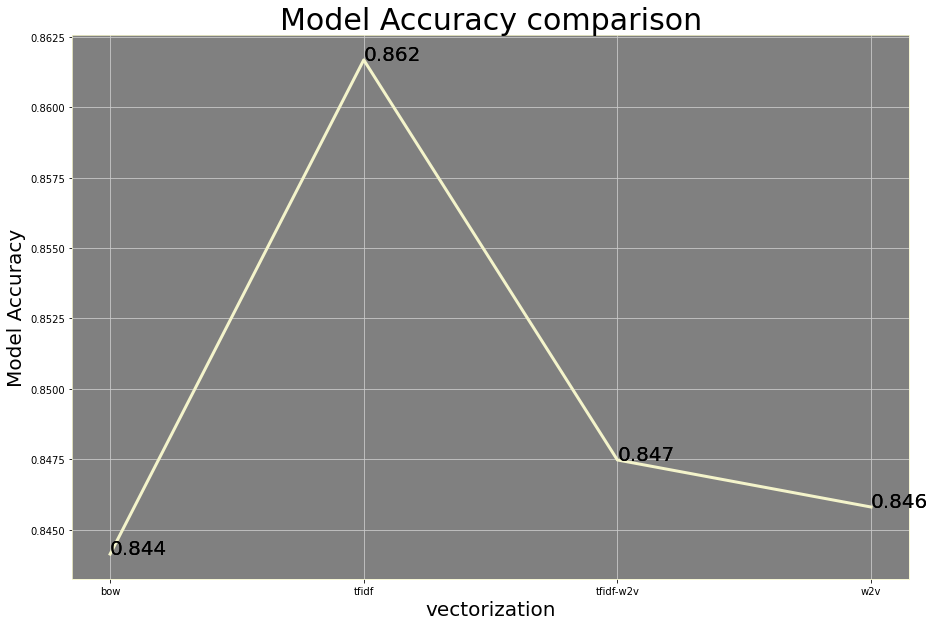

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(test,test_acc,color='#F4F4CB',linewidth=3)
plt.xlabel('vectorization',size=20)
plt.ylabel('Model Accuracy',size=20)
plt.title('Model Accuracy comparison',size=30)
plt.rcParams['axes.facecolor'] = 'grey'
plt.rcParams['axes.edgecolor'] = '#F4F4CB'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
for i,j in zip(test,test_acc):
 plt.annotate(round(j,3),xy=(i,j), size=20)
for i,j in zip(test,test_acc):
 plt.annotate(round(j,3),xy=(i,j), size=20)   
plt.show() 

# ***2. Model : Logistic Regression***

In [40]:
accuracy_LR_tr = []
accuracy_LR_test = []

# *2.1 BOW*

In [41]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_tr_bow)
X_tr=scaler.transform(X_tr_bow)

scaler.fit(X_test_bow)
X_test=scaler.transform(X_test_bow)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
logistic = LogisticRegression()
distributions = dict(C=np.random.uniform(0,10000,1000),penalty=['l2', 'l1'])
clf = RandomizedSearchCV(logistic, distributions, random_state=0)
search = clf.fit(X_tr, y_tr_bow)
c = search.best_params_['C']
p = search.best_params_['penalty']
print('penalty is {0} and C is {1} for {2}.'.format(p,c,'tfidf'))

from sklearn.metrics import accuracy_score 
model = LogisticRegression(C = c, penalty=p )
model.fit(X, y_tr_bow)
pred_tr = model.predict(X_tr)
acc_tr = accuracy_score(pred_tr,y_tr_bow)
pred_test = model.predict(X_test)
acc_test = accuracy_score(pred_test, y_test_bow)
print(acc_tr,acc_test)
accuracy_LR_tr.append(acc_tr)
accuracy_LR_test.append(acc_test)

penalty is l2 and C is 4156.041225531614 for tfidf.
1.0 0.8946928541579607


# *2.2. TFIDF*

In [42]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_tr_tfidf)
X_tr=scaler.transform(X_tr_tfidf)

scaler.fit(X_test_tfidf)
X_test=scaler.transform(X_test_tfidf)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
logistic = LogisticRegression()
distributions = dict(C=np.random.uniform(0,10000,1000),penalty=['l2'])
clf = RandomizedSearchCV(logistic, distributions, random_state=0)
search = clf.fit(X_tr, y_tr_bow)
c = search.best_params_['C']
p = search.best_params_['penalty']
print('penalty is {0} and C is {1} for {2}.'.format(p,c,'tfidf'))

from sklearn.metrics import accuracy_score 
model = LogisticRegression(C = c, penalty=p )
model.fit(X_tr, y_tr_bow)
pred_tr = model.predict(X_tr)
acc_tr = accuracy_score(pred_tr,y_tr_bow)
pred_test = model.predict(X_test)
acc_test = accuracy_score(pred_test, y_test_bow)
print(acc_tr,acc_test)

accuracy_LR_tr.append(acc_tr)
accuracy_LR_test.append(acc_test)

penalty is l2 and C is 327.6269324375247 for tfidf.
1.0 0.9005432511491851


# *2.3. TFIDF-W2V*

In [43]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_tr_tfidf_w2v)
X_tr=scaler.transform(X_tr_tfidf_w2v)

scaler.fit(X_test_tfidf_w2v)
X_test=scaler.transform(X_test_tfidf_w2v)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
logistic = LogisticRegression()
distributions = dict(C=np.random.uniform(0,10000,1000),penalty=['l2'])
clf = RandomizedSearchCV(logistic, distributions, random_state=0)
search = clf.fit(X_tr, y_tr_tfidf_w2v)
c = search.best_params_['C']
p = search.best_params_['penalty']
print('penalty is {0} and C is {1} for {2}.'.format(p,c,'tfidf'))

from sklearn.metrics import accuracy_score 
model = LogisticRegression(C = c, penalty=p )
model.fit(X_tr, y_tr_tfidf_w2v)
pred_tr = model.predict(X_tr)
acc_tr = accuracy_score(pred_tr,y_tr_tfidf_w2v)
pred_test = model.predict(X_test)
acc_test = accuracy_score(pred_test, y_test_tfidf_w2v)
print(acc_tr,acc_test)

accuracy_LR_tr.append(acc_tr)
accuracy_LR_test.append(acc_test)

penalty is l2 and C is 5752.005249683946 for tfidf.
0.8722961730449251 0.8692018386961973


# *2.4. Avg-W2V*

In [44]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_tr_avgw2v)
X_tr=scaler.transform(X_tr_avgw2v)

scaler.fit(X_test_avgw2v)
X_test=scaler.transform(X_test_avgw2v)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
logistic = LogisticRegression()
distributions = dict(C=np.random.uniform(0,10000,1000),penalty=['l2'])
clf = RandomizedSearchCV(logistic, distributions, random_state=0)
search = clf.fit(X_tr, y_tr_avgw2v)
c = search.best_params_['C']
p = search.best_params_['penalty']
print('penalty is {0} and C is {1} for {2}.'.format(p,c,'tfidf'))

from sklearn.metrics import accuracy_score 
model = LogisticRegression(C = c, penalty=p )
model.fit(X_tr, y_tr_avgw2v)
pred_tr = model.predict(X_tr)
acc_tr = accuracy_score(pred_tr,y_tr_avgw2v)
pred_test = model.predict(X_test)
acc_test = accuracy_score(pred_test, y_test_avgw2v)
print(acc_tr,acc_test)

accuracy_LR_tr.append(acc_tr)
accuracy_LR_test.append(acc_test)

penalty is l2 and C is 5768.957883258214 for tfidf.
0.8560732113144759 0.8549937317175094


# *2.5. Plotting Train data  accuracy with Test data*

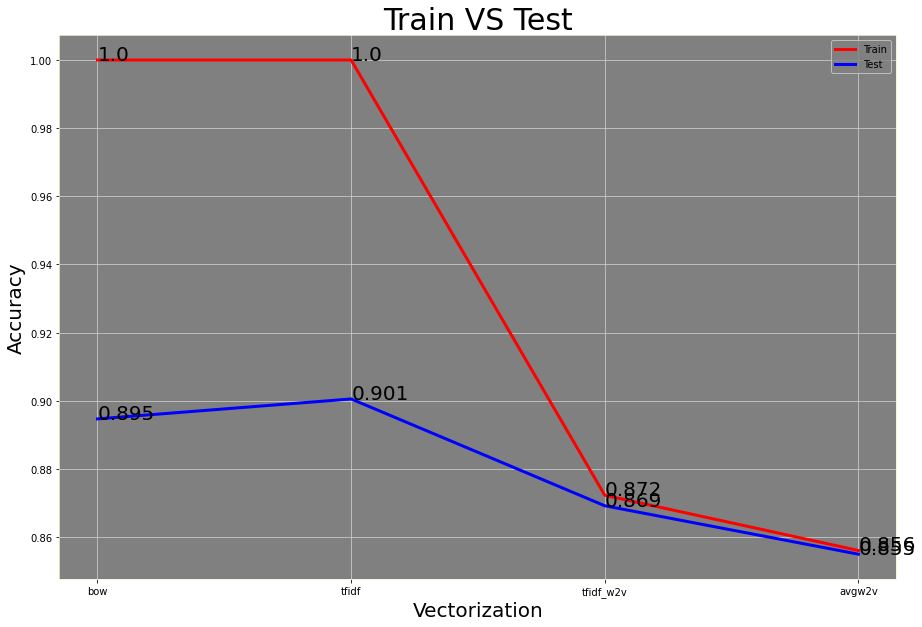

In [49]:
models = ['bow', 'tfidf','tfidf_w2v','avgw2v']

plt.figure(figsize=(15,10))
plt.plot(models,accuracy_LR_tr,color='red',linewidth=3)
plt.plot(models,accuracy_LR_test,color='blue',linewidth=3)
plt.xlabel('Vectorization',size=20)
plt.ylabel('Accuracy',size=20)
plt.title('Train VS Test',size=30)
plt.legend(['Train','Test'])
plt.rcParams['axes.facecolor'] = 'grey'
plt.rcParams['axes.edgecolor'] = '#F4F4CB'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
for i,j in zip(models,accuracy_LR_tr):
 plt.annotate(round(j,3),xy=(i,j), size=20)
for i,j in zip(models,accuracy_LR_test):
 plt.annotate(round(j,3),xy=(i,j), size=20)   
plt.show() 